In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arketing-campaign/marketing_campaign.csv
/kaggle/input/arketing-campaign/marketing_campaign.xlsx
/kaggle/input/00-marketing-campaign-data-processing/__results__.html
/kaggle/input/00-marketing-campaign-data-processing/__notebook__.ipynb
/kaggle/input/00-marketing-campaign-data-processing/__output__.json
/kaggle/input/00-marketing-campaign-data-processing/custom.css
/kaggle/input/00-marketing-campaign-data-processing/processed/hypothesis_ready.csv
/kaggle/input/00-marketing-campaign-data-processing/processed/processed.csv
/kaggle/input/00-marketing-campaign-data-processing/processed/processed.pkl


In [1]:
!pip install causalml

In [4]:
from lightgbm import LGBMRegressor

In [5]:
IN_PATH = '/kaggle/input/00-marketing-campaign-data-processing/'
HYP_DATA = IN_PATH + 'processed/hypothesis_ready.csv'
df = pd.read_csv(HYP_DATA)
df['Response'] = (df['Response']>0).astype(int)
df.head()

,ID,Year_Birth,Age,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,TotalSpend,AcceptedCnt
0,5524,1957,68,Graduation,Single,58138.0,0,0,2012-09-04,58,...,7,0,0,0,0,0,0,1,1617,0
1,2174,1954,71,Graduation,Single,46344.0,1,1,2014-03-08,38,...,5,0,0,0,0,0,0,0,27,0
2,4141,1965,60,Graduation,Together,71613.0,0,0,2013-08-21,26,...,4,0,0,0,0,0,0,0,776,0
3,6182,1984,41,Graduation,Together,26646.0,1,0,2014-02-10,26,...,6,0,0,0,0,0,0,0,53,0
4,5324,1981,44,PhD,Married,58293.0,1,0,2014-01-19,94,...,5,0,0,0,0,0,0,0,422,0


In [6]:
outcome = 'TotalSpend'
treatment = 'Response'

feature_cols = [
    'Age', 'Income', 'Kidhome', 'Teenhome', 'Recency', 
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
    'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 
    'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 
    'NumWebVisitsMonth', 'AcceptedCnt', 'Complain',
]

categorical_cols = ['Education', 'Marital_Status']

df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

final_feature_cols = feature_cols + [col for col in df_processed.columns if any(cat_col in col for cat_col in categorical_cols)]

df_processed = df_processed.fillna(0)

df_processed[final_feature_cols].head()

,Age,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,68,58138.0,0,0,58,635,88,546,172,88,...,True,False,False,False,False,False,True,False,False,False
1,71,46344.0,1,1,38,11,1,6,2,1,...,True,False,False,False,False,False,True,False,False,False
2,60,71613.0,0,0,26,426,49,127,111,21,...,True,False,False,False,False,False,False,True,False,False
3,41,26646.0,1,0,26,11,4,20,10,3,...,True,False,False,False,False,False,False,True,False,False
4,44,58293.0,1,0,94,173,43,118,46,27,...,False,False,True,False,False,True,False,False,False,False


In [7]:
X_df = df_processed[final_feature_cols]
X_df = X_df.astype(int)
X = X_df.to_numpy()
T = df_processed[treatment].to_numpy()
y = df_processed[outcome].to_numpy()

print(f"X (Feature) shape: {X.shape}")
print(f"T (Treatment) shape: {T.shape}")
print(f"y (Outcome) shape: {y.shape}")

X (Feature) shape: (2229, 29)
T (Treatment) shape: (2229,)
y (Outcome) shape: (2229,)


In [8]:
class XLearner:
    """
    - fit: outcome model(μ0, μ1) → imputed effect(d0, d1) → effect model(τ0, τ1)
    - predict: return τ(x) 
    """
    def __init__(self, mu0=None, mu1=None, tau0=None, tau1=None, random_state: int = 42):
        self.mu0 = mu0 or LGBMRegressor(verbose=-1,n_estimators=400)  # type: ignore
        self.mu1 = mu1 or LGBMRegressor(verbose=-1,n_estimators=400)  # type: ignore
        self.tau0 = tau0 or LGBMRegressor(verbose=-1,n_estimators=400)  # type: ignore
        self.tau1 = tau1 or LGBMRegressor(verbose=-1,n_estimators=400)  # type: ignore
        self.p_t = 0.5
        self.random_state = random_state

    def fit(self, X: np.ndarray, T: np.ndarray, y: np.ndarray):

        X0, y0 = X[T == 0], y[T == 0]
        X1, y1 = X[T == 1], y[T == 1]

        self.mu0.fit(X0, y0)    # Use only Control data
        self.mu1.fit(X1, y1)    # Use only Treatment data

        # Imputed effects: 
        d0 = self.mu1.predict(X0) - y0
        d1 = y1 - self.mu0.predict(X1)

        # 3) Effect models(τ0, τ1)
        self.tau0.fit(X0, d0)    # Use X0 and Predict d0
        self.tau1.fit(X1, d1)    # Use X1 and Predict d1

        self.p_t = float(T.mean())
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Final CATE prediction: (1-p_t)*τ0(x) + p_t*τ1(x)"""
        w0 = 1 - self.p_t
        w1 = self.p_t
        return w0 * self.tau0.predict(X) + w1 * self.tau1.predict(X)

In [9]:
def fit_xlearner(X: np.ndarray, T: np.ndarray, y: np.ndarray) -> XLearner:
    return XLearner().fit(X, T, y)

In [10]:
def predict_cate(model: XLearner, X_new: np.ndarray) -> np.ndarray:
    return model.predict(X_new)

In [16]:
import warnings

warnings.filterwarnings("ignore", message="No further splits with positive gain, best gain: -inf")

In [17]:
x_model = fit_xlearner(X, T, y)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

In [18]:
# Predict CATE(Uplift) for every customer
cate_predictions = predict_cate(x_model, X)

print("\nPredicted CATE score (Top 5):")
print(cate_predictions[:5])


Predicted CATE score (Top 5):
[-72.47171695  -9.17822341  43.35694666   5.91126624  53.12662508]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<h2>Results</h2>

In [19]:
FIG_PATH = '/kaggle/working/figure'
os.makedirs(FIG_PATH, exist_ok=True)

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


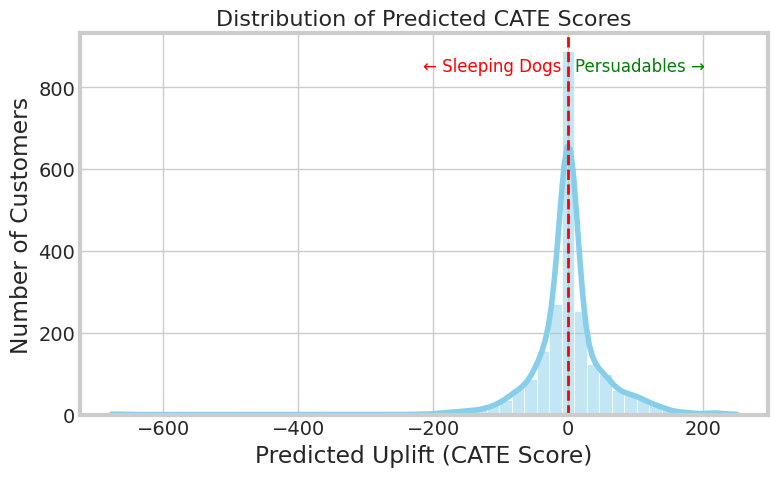

In [46]:
plt.figure(figsize=(8, 5))

sns.histplot(cate_predictions, kde=True, bins=50, color='skyblue',)

plt.axvline(x=0, color='red', linestyle='--', linewidth=2)

plt.title('Distribution of Predicted CATE Scores', fontsize=16)
plt.xlabel('Predicted Uplift (CATE Score)')
plt.ylabel('Number of Customers')
y_axis_max = plt.ylim()[1]
plt.text(10, y_axis_max * 0.9, 'Persuadables →', ha='left', color='green', fontsize=12)
plt.text(-10, y_axis_max * 0.9, '← Sleeping Dogs', ha='right', color='red', fontsize=12)
plt.tight_layout()
plt.savefig(FIG_PATH + "/predicted_CATE_distribution.png", dpi=200, bbox_inches='tight')
plt.show()

In [59]:
df_lift = pd.DataFrame({
    'cate': cate_predictions,
    'treatment': df[treatment],
    'outcome': df[outcome]
})

df_lift = df_lift.sort_values(by='cate', ascending=False).reset_index(drop=True)

df_lift['decile'] = pd.qcut(df_lift.index, q=10, labels=False, duplicates='drop')

grouped = df_lift.groupby('decile')
lift_df = pd.DataFrame()
lift_df['n_treatment'] = grouped['treatment'].sum()
lift_df['n_control'] = grouped['treatment'].count() - grouped['treatment'].sum()
lift_df['outcome_treatment'] = grouped.apply(lambda df: df.loc[df['treatment'] == 1, 'outcome'].sum())
lift_df['outcome_control'] = grouped.apply(lambda df: df.loc[df['treatment'] == 0, 'outcome'].sum())

lift_df['mean_outcome_treatment'] = lift_df['outcome_treatment'] / lift_df['n_treatment'].replace(0, 1)
lift_df['mean_outcome_control'] = lift_df['outcome_control'] / lift_df['n_control'].replace(0, 1)

lift_df['uplift'] = lift_df['mean_outcome_treatment'] - lift_df['mean_outcome_control']

lift_df['total_uplift_effect'] = lift_df['uplift'] * lift_df['n_treatment']

lift_df['cumulative_n_treatment'] = lift_df['n_treatment'].cumsum()
lift_df['cumulative_uplift_effect'] = lift_df['total_uplift_effect'].cumsum()
lift_df['cumulative_mean_uplift'] = lift_df['cumulative_uplift_effect'] / lift_df['cumulative_n_treatment']

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


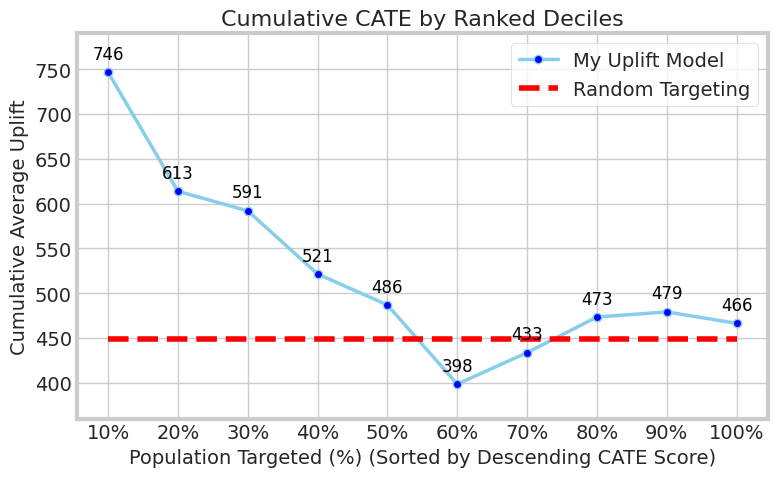

In [65]:
plt.figure(figsize=(8, 5))
x_values = np.arange(1, 11)
y_values = lift_df['cumulative_mean_uplift']
plt.plot(x_values, y_values, marker='o', mfc='blue',
         label='My Uplift Model', linewidth=2.5, color='skyblue')

for x, y in zip(x_values, y_values):
    plt.text(x, y + 15, f'{int(y)}', ha='center', fontsize=12, color='black')


overall_uplift = (df_lift[df_lift['treatment'] == 1]['outcome'].mean() - 
                  df_lift[df_lift['treatment'] == 0]['outcome'].mean())
plt.plot(np.arange(1, 11), [overall_uplift] * 10, linestyle='--', color='red', label='Random Targeting')

plt.ylim([360, 790])
plt.title('Cumulative CATE by Ranked Deciles', fontsize=16)
plt.xlabel('Population Targeted (%) (Sorted by Descending CATE Score)', fontsize=14)
plt.ylabel('Cumulative Average Uplift', fontsize=14)
plt.xticks(np.arange(1, 11), [f'{i*10}%' for i in range(1, 11)])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(FIG_PATH + "/Uplift_Curve.png", dpi=200, bbox_inches='tight')
plt.show()
